# Retinal blood vessels detection
#### by Michał Pawlicki & Agnieszka Grzymska

### 1. Image preprocessing - histogram equalization

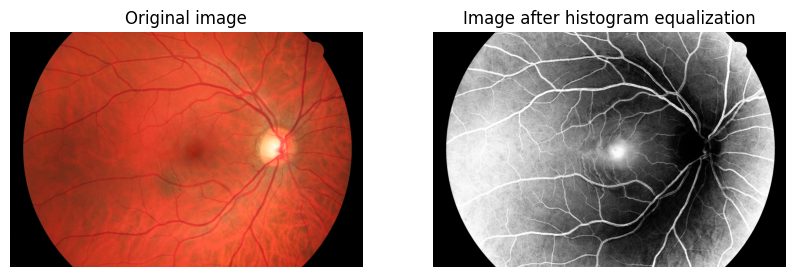

In [77]:
import sklearn
import imblearn
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from skimage.filters import hessian, frangi

def get_green_channel(img):
    _, green_img, _ = cv.split(img)
    green_img = invert_colors(green_img)
    return green_img

def invert_colors(img):
    new_image = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for x, row in enumerate(img):
        for y, _ in enumerate(row):
            new_image[x][y] = abs(255 - img[x][y])
    return new_image

images_paths = os.listdir('input/healthy/images')
images = []

for path in images_paths[:1]:
    initial_img = cv.imread("input/healthy/images/" + path, cv.IMREAD_COLOR)
    assert initial_img is not None, "file could not be read, check with os.path.exists()"
    initial_img = cv.cvtColor(initial_img, cv.COLOR_BGR2RGB)
    img_mask = cv.imread("input/healthy/masks/" + path[:-4] + "_mask.tif", cv.IMREAD_GRAYSCALE)
    img = get_green_channel(initial_img)
    result = cv.bitwise_and(img, img, mask=img_mask)
    equ = cv.equalizeHist(result)
    images.append(equ)

    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(initial_img)
axs[0].set_title('Original image')
axs[0].axis('off')
axs[1].imshow(cv.cvtColor(equ, cv.COLOR_BGR2RGB))
axs[1].set_title('Image after histogram equalization')
axs[1].axis('off')

plt.show()

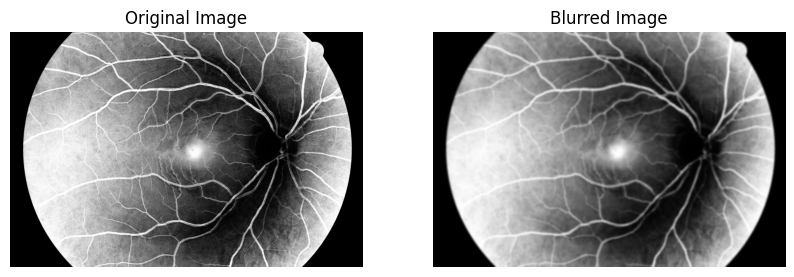

In [78]:
img = cv.GaussianBlur(equ, (51,51), 0)

# Display the original image and the blurred image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(equ, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(img, cmap='gray')
axs[1].set_title('Blurred Image')
axs[1].axis('off')

plt.show()

### 2. Proper processing - Hessian filter

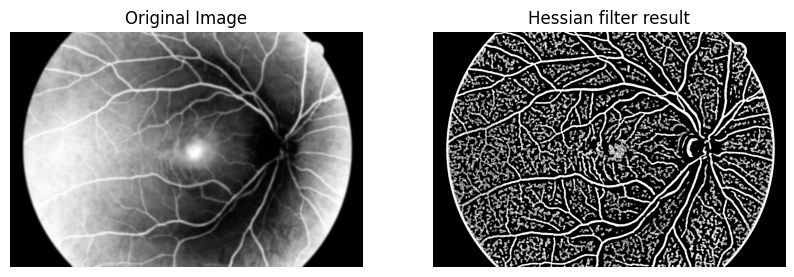

In [112]:
hes_img = hessian(img)
hes_img = cv.bitwise_and(hes_img, hes_img, mask=img_mask)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(result, cmap='gray')
axs[1].set_title('Hessian filter result')
axs[1].axis('off')

plt.show()

### 3. Final image processing

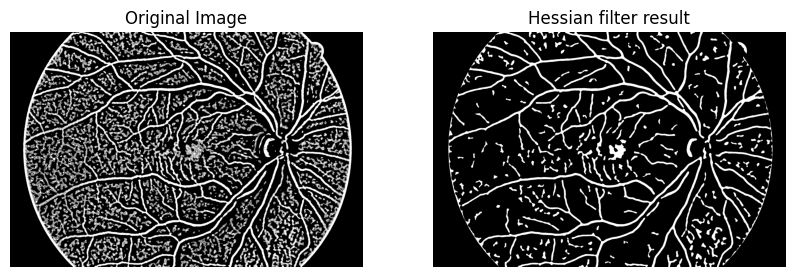

In [109]:
def noise_removing(img, min_size = 600):
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(img, connectivity=8)
    sizes = stats[1:, -1]
    clear_img = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    for i in range(0, nb_components - 1):
        if sizes[i] >= min_size:
            clear_img[output == i + 1] = 255
    return clear_img

def retina_circle_removing(img, base_offset=2000):
    no_retina_img = img.copy()
    circle = np.zeros(img.shape, np.uint8)
    offset = 0
    detections = []
    while True:
        detections = cv.HoughCircles(no_retina_img, cv.HOUGH_GRADIENT, 1.5, base_offset + offset)
        if detections is None:
            return no_retina_img
        if len(detections[0]) == 1:
            break
        offset += 100
    for (x, y, r) in detections[0]:
        cv.circle(circle, (int(x), int(y)), int(r), (255, 255, 255), 40)
    no_retina_img = no_retina_img - circle
    return no_retina_img

def remove_retina_circle(img, base_offset=2000):
    no_retina_img = img.copy()
    circle = np.zeros(img.shape, np.uint8)
    offset = 0
    while True:
        detections = cv.HoughCircles(no_retina_img, cv.HOUGH_GRADIENT, 1.5, base_offset + offset)
        if detections is None:
            return no_retina_img
        if len(detections[0]) == 1:
            break
        offset += 100
    for (x, y, r) in detections[0]:
        cv.circle(circle, (int(x), int(y)), int(r), (255, 255, 255), 40)
    no_retina_img = no_retina_img - circle
    return no_retina_img



filtered_img = cv.bilateralFilter(np.uint8(hes_img),30,80,80)
filtered_img = noise_removing(filtered_img)
filtered_img = retina_circle_removing(filtered_img)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(result, cmap='gray')
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(filtered_img, cmap='gray')
axs[1].set_title('Hessian filter result')
axs[1].axis('off')

plt.show()